In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Обработка данных

Посмотрим на данные, которые мы спарсили:

In [5]:
data = pd.read_csv('car_data.csv', sep=';')
data.head()

,engine,power,transmission,drive_unit,body_type,color,mileage,steering_wheel,gen,equipment,price
0,1.6,102.0,механика,передний,NaN,серебристый,145000.0,левый,2.0,1.6 MT Stepway Privilege,860000.0
1,2.0,184.0,АКПП,4WD,купе,черный,123000.0,левый,5.0,E 200 4MATIC Sport,3900000.0
2,1.5,131.0,вариатор,передний,NaN,черный,20000.0,правый,1.0,1.5 RS Honda Sensing,1620000.0
3,1.2,79.0,АКПП,передний,NaN,серый,100000.0,правый,2.0,1.2 e-POWER X,995000.0
4,2.2,200.0,АКПП,4WD,NaN,серый,3100.0,левый,1.0,2.2 CRDi AT 4WD High-Tech 7 мест,5150000.0


Имеем следующие фичи:


*   engine: объём двигателя
*   power: мощность в л. с.
*   transmission: тип коробки передач
*   drive_unit: тип привода
*   body_type: тип кузова
*   color: цвет
*   mileage: пробег
*   steering_wheel: руль (с какой стороны он находится)
*   gen: поколение автомобиля
*   equipment: комплектация
*   price: цена автомобиля и по совместительству наша целевая переменная



Посмотрим, сколько пропусков в данных:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   engine          1989 non-null   float64
 1   power           1990 non-null   float64
 2   transmission    1997 non-null   object 
 3   drive_unit      1995 non-null   object 
 4   body_type       877 non-null    object 
 5   color           1934 non-null   object 
 6   mileage         1796 non-null   float64
 7   steering_wheel  1948 non-null   object 
 8   gen             1960 non-null   float64
 9   equipment       1284 non-null   object 
 10  price           2000 non-null   float64
dtypes: float64(5), object(6)
memory usage: 172.0+ KB


Видим, что записей в body_type меньше половины. Пока откинем этот признак - **позже надо придумать что-нибудь более умное**

Определим числовые и категориальные фичи:

In [7]:
num_cols = ['engine',
            'power',
            'mileage',
            'gen']

cat_cols = ['transmission',
            'drive_unit',
            # 'body_type',
            'color',
            'steering_wheel',
            'equipment']

target = 'price'

Посмотрим на значения категориальных признаков:

In [8]:
for col in cat_cols:
    print(data[col].value_counts(), '\n')

АКПП        882
вариатор    565
механика    394
робот       106
автомат      50
Name: transmission, dtype: int64 

передний    1212
4WD           653
задний       130
Name: drive_unit, dtype: int64 

белый          525
черный         411
серый          327
серебристый    193
синий          155
зеленый         60
красный         59
коричневый      56
бордовый        45
бежевый         34
оранжевый       23
голубой         19
фиолетовый      16
золотистый       6
желтый           5
Name: color, dtype: int64 

левый     1205
правый     743
Name: steering_wheel, dtype: int64 

1.5 CVT Prestige                      28
1.5 CVT Elite                         20
1.5 X                                 12
1.6 DCT Ultimate                      12
1.5 MT Базовая                        10
                                      ..
C 180 BlueEFFICIENCY AT Avantgarde     1
2.0 AT 4WD GLS                         1
xDrive 20i AT M Sport Model            1
1.6 EcoBoost AT 4WD Trend Plus  

В признаке equipment очень много уникальных значений. Не думаю, что он поможет правильно обучить модель - отбросим его.

In [9]:
cat_cols = ['transmission',
            'drive_unit',
            'color',
            'steering_wheel']

data = data[num_cols+cat_cols+[target]]

Также визуализируем полученный выше результат:

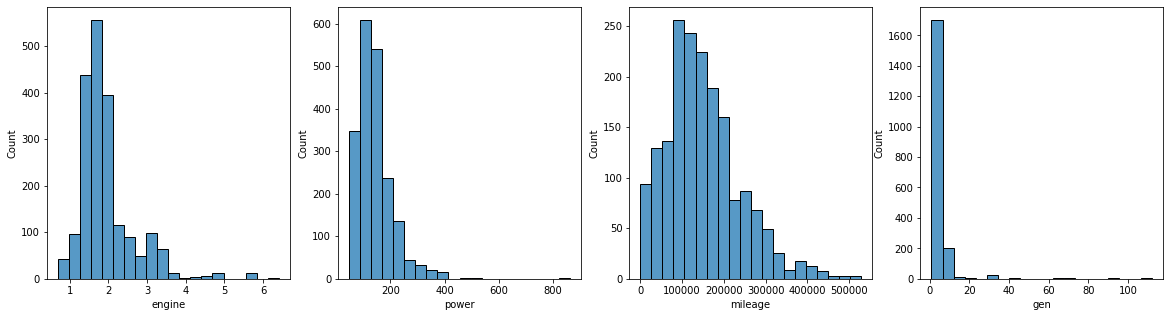

In [10]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.histplot(data, x=col, bins=20)

plt.show()

Можно будет попробовать увеличить скор модели за счёт отбрасывания одного из **высокоскореллированных признаков**:

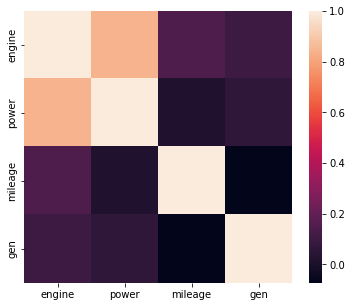

In [33]:
plt.figure(figsize=(6, 5))

sns.heatmap(data[num_cols].corr())

plt.show()

Видим, что данные имеют существенно разный масштаб $-$ далее нужно будет их отнормировать. Также следует подробнее изучить признак gen и его получение в процессе парсинга $-$ странно, что есть автомобили 100 поколения.

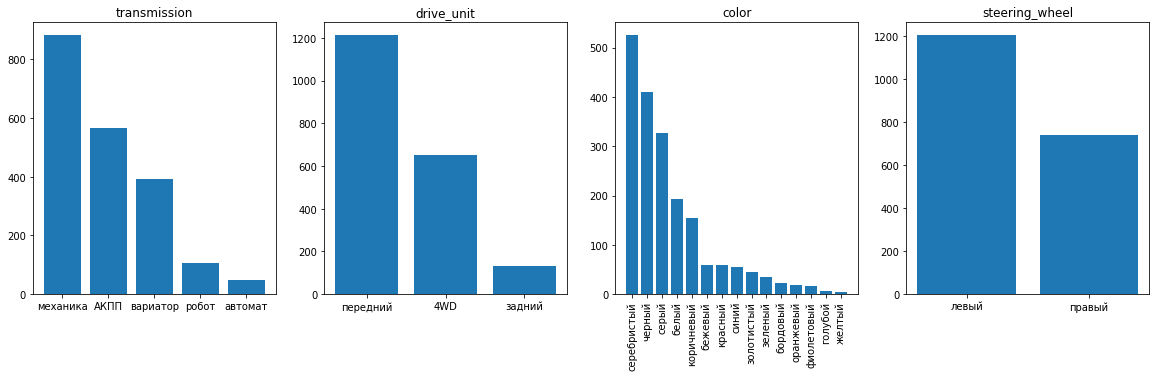

In [11]:
plt.figure(figsize=(20, 5))

for i , col in enumerate(cat_cols):
    plt.subplot(1, len(cat_cols), i+1)
    if col == 'color':
        plt.xticks(rotation='vertical')
    plt.bar(pd.Series(data[col].unique()).dropna(), data[col].value_counts())
    plt.title(col)

plt.show()

По категориальным признакам данные распределены не равномерно $-$ следует учесть это в дальнейшем.

Пока просто дропну NaN'ы:

In [12]:
print(f"Было: {data.shape}")
data = data.dropna()
print(f"Стало: {data.shape}")

y = data[target]
data = data[num_cols+cat_cols]

Было: (2000, 9)
Стало: (1643, 9)


Так как мы решаем задачу регрессии, стоит отнормировать числовые признаки. Также закодируем категориальные признаки one-hot-encoding'ом. Напишем пайплайн для обработки данных:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [14]:
def pipe(model):

    scaler = StandardScaler()
    ohe = OneHotEncoder()

    # Пайплайн для числовых признаков
    num_selector = FunctionTransformer(lambda data: data[num_cols], validate=False)
    num_processor = Pipeline([('num_selector', num_selector), ('scaler', scaler)])

    # Пайплайн для категориальных признаков
    cat_selector = FunctionTransformer(lambda data: data[cat_cols], validate=False)
    cat_processor = Pipeline  ([('cat_selector', cat_selector), ('ohe', ohe)])

    # Объединяем пайплайн в итоговый
    feature_union = FeatureUnion([('num_processor', num_processor), ('cat_processor', cat_processor)])
    pipeline = Pipeline([('preprocessing', feature_union), ('modeling', model)])

    return pipeline

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Обучение моделей

In [16]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

**1. Линейная регрессия**

In [34]:
model = LinearRegression()
pipe_1 = pipe(model)
pipe_1.fit(X_train, y_train)

y_pred = pipe_1.predict(X_test)
print(f"r2_score = {r2_score(y_test, y_pred)}")

r2_score = 0.5743641681593581


**2. Регрессия с регуляризацией**

In [18]:
from sklearn.linear_model import ElasticNet

In [25]:
model = ElasticNet(random_state=42)

params = {'modeling__alpha': np.linspace(0, 1, 11),
          'modeling__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

grid_search = GridSearchCV(estimator=pipe(model), param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(data, y)
None

In [20]:
print(f"Best score: {grid_search.best_score_}")
grid_search.best_params_

Best score: 0.5348873399012136


{'modeling__alpha': 0.1, 'modeling__l1_ratio': 0.5}

**3. Градиентный бустинг**

In [28]:
model = GradientBoostingRegressor(random_state=42)

params = {'modeling__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
          'modeling__n_estimators': [50, 100, 150, 200, 250],
          'modeling__max_depth': np.arange(1, 6)}

grid_search = GridSearchCV(estimator=pipe(model), param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(data, y)
None

In [29]:
print(f"Best score: {grid_search.best_score_}")
grid_search.best_params_

Best score: 0.8967769130269735


{'modeling__learning_rate': 0.1,
 'modeling__max_depth': 5,
 'modeling__n_estimators': 250}

Градиентный бустинг выдал вполне хороший результат.

# Сравнение моделей